# Single Event with Complex Analysis

## Part Two (ML Training)

#### Prerequisites
This notebook is designed to work with a Stroom server process running on `localhost`, into which data from `EventGen` application has been ingested and indexed in the manner described in `stroom-analytic-demo`.

You must set the environmental variable `STROOM_API_KEY` to the API token associated with a suitably privileged Stroom user account before starting the Jupyter notebook server process.

In [26]:
from pyspark.sql.types import *
from pyspark.sql.functions import from_json, col, coalesce, unix_timestamp,lit,to_timestamp,hour,date_format,date_trunc
from pyspark.ml.feature import OneHotEncoderEstimator,VectorAssembler,StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from IPython.display import display
import time,os

#### Schema Discovery
It is necessary to specify the structure of the JSON data arriving on the topic.  This structure can be determined at runtime.

As the same format of data is also available via an indexed search using the `stroom-spark-datasource`, one way to determine the JSON schema is by interrogating the data held in the `Sample Index` Stroom index.

The specified pipeline is a Stroom Search Extraction Pipeline that uses the stroom:json XSLT function to create a JSON representation of the entire event.  This field is called "Json" by default but the name of the field that contains the JSON representation can (optionally) be changed with the parameter jsonField.

In this manner, all data is returned as a single JSON structure within the field **json**

In [37]:
spark = SparkSession \
    .builder \
    .appName("MyTestApp") \
    .getOrCreate()
schemaDf = spark.read.format('stroom.spark.datasource.StroomDataSource').load(
        token=os.environ['STROOM_API_KEY'],host='localhost',protocol='http',
        uri='api/stroom-index/v2',traceLevel="0",
        index='32dfd401-ee11-49b9-84c9-88c3d3f68dc2',pipeline='13143179-b494-4146-ac4b-9a6010cada89',
        maxResults='300000').filter((col('idxEventTime') > '2018-01-01T00:00:00.000Z')
            & (col('idxEventTime') < '2019-01-01T00:00:00.000Z')
            & (col('idxDescription') == 'Authentication Failure'))

print ('Using ', schemaDf.count(), ' records for training')
json_schema = spark.read.json(schemaDf.rdd.map(lambda row: row.json)).schema

json_schema

Using  56889  records for training


StructType(List(StructField(EventDetail,StructType(List(StructField(Authenticate,StructType(List(StructField(Action,StringType,true),StructField(Outcome,StructType(List(StructField(Permitted,StringType,true),StructField(Reason,StringType,true),StructField(Success,StringType,true))),true),StructField(User,StructType(List(StructField(Id,StringType,true))),true))),true),StructField(TypeId,StringType,true))),true),StructField(EventId,StringType,true),StructField(EventSource,StructType(List(StructField(Device,StructType(List(StructField(HostName,StringType,true))),true),StructField(Generator,StringType,true),StructField(System,StructType(List(StructField(Environment,StringType,true),StructField(Name,StringType,true))),true))),true),StructField(EventTime,StructType(List(StructField(TimeCreated,StringType,true))),true),StructField(StreamId,StringType,true)))

## Feature Engineering
Creating a feature vector suitable for ML

In [38]:
featuresDf = schemaDf.withColumn('evt', from_json(col('json'), json_schema)).\
    withColumn ('timestamp', to_timestamp(col('evt.EventTime.TimeCreated')).cast("timestamp")).\
    where(col("timestamp") < '2019-01-01').\
    withColumn('operation', col('evt.EventDetail.TypeId')).\
    groupBy(date_trunc('day',"timestamp").alias("date"), 
            date_format('timestamp', 'EEEE').alias("day"), 
            hour("timestamp").alias("hour"),
            col('operation')).\
    count().sort(col('date'),col('hour'))


# operationNameIndexer = StringIndexer(inputCol="operation",outputCol="opCat")
# operationEncoder = OneHotEncoderEstimator(inputCols=['opCat'],outputCols=['opVec'])
hourEncoder = OneHotEncoderEstimator(inputCols=['hour'],outputCols=['hourVec'])
dayNameIndexer = StringIndexer(inputCol="day",outputCol="dayCat")
dayEncoder = OneHotEncoderEstimator(inputCols=['dayCat'],outputCols=['dayVec'])
basicPipeline = Pipeline(stages=[hourEncoder, dayNameIndexer, dayEncoder])

vecDf = basicPipeline.fit(featuresDf).transform(featuresDf)
vecDf.show()


+-------------------+-------+----+--------------------+-----+---------------+------+-------------+
|               date|    day|hour|           operation|count|        hourVec|dayCat|       dayVec|
+-------------------+-------+----+--------------------+-----+---------------+------+-------------+
|2018-01-01 00:00:00| Monday|  12|Authentication Fa...|   11|(23,[12],[1.0])|   4.0|(6,[4],[1.0])|
|2018-01-01 00:00:00| Monday|  13|Authentication Fa...|   33|(23,[13],[1.0])|   4.0|(6,[4],[1.0])|
|2018-01-01 00:00:00| Monday|  14|Authentication Fa...|   15|(23,[14],[1.0])|   4.0|(6,[4],[1.0])|
|2018-01-01 00:00:00| Monday|  15|Authentication Fa...|   24|(23,[15],[1.0])|   4.0|(6,[4],[1.0])|
|2018-01-01 00:00:00| Monday|  16|Authentication Fa...|   11|(23,[16],[1.0])|   4.0|(6,[4],[1.0])|
|2018-01-01 00:00:00| Monday|  17|Authentication Fa...|   10|(23,[17],[1.0])|   4.0|(6,[4],[1.0])|
|2018-01-01 00:00:00| Monday|  18|Authentication Fa...|   14|(23,[18],[1.0])|   4.0|(6,[4],[1.0])|
|2018-01-0

We can now create the entire feature vector.  Shown below with what will be the required output vector (actually a simple scalar "count")

In [39]:
vectorAssembler = VectorAssembler(inputCols = ['hourVec','dayVec'], outputCol = 'features')

trainingDf = vectorAssembler.transform(vecDf).select('features','count')

trainingDf.show()


+--------------------+-----+
|            features|count|
+--------------------+-----+
|(29,[12,27],[1.0,...|   11|
|(29,[13,27],[1.0,...|   33|
|(29,[14,27],[1.0,...|   15|
|(29,[15,27],[1.0,...|   24|
|(29,[16,27],[1.0,...|   11|
|(29,[17,27],[1.0,...|   10|
|(29,[18,27],[1.0,...|   14|
|(29,[19,27],[1.0,...|   11|
|(29,[20,27],[1.0,...|    5|
|(29,[21,27],[1.0,...|    2|
|(29,[22,27],[1.0,...|    2|
|     (29,[27],[1.0])|    3|
|(29,[0,25],[1.0,1...|    2|
|(29,[1,25],[1.0,1...|    1|
|(29,[2,25],[1.0,1...|    2|
|(29,[3,25],[1.0,1...|    3|
|(29,[4,25],[1.0,1...|    1|
|(29,[5,25],[1.0,1...|    1|
|(29,[7,25],[1.0,1...|    2|
|(29,[8,25],[1.0,1...|    8|
+--------------------+-----+
only showing top 20 rows



## Training
Now create a Logistic Regression classifier to predict the number of auth failures in each hour/day of week.
Save the model for later use.

In [40]:
lr = LogisticRegression(maxIter=10, regParam=0.001, featuresCol='features', labelCol='count')

lrModel = lr.fit(trainingDf)

lrModel.save("lrAuthFailuresModel")

## Assessment
There are many ways that an ML model could be refined and improved.  Here we are only interested in understanding whether the model fits newer data.


In [42]:
lrModel.transform(trainingDf).show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|count|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(29,[12,27],[1.0,...|   11|[-2.7456508843618...|[6.04109790047702...|      19.0|
|(29,[13,27],[1.0,...|   33|[-2.7481406864495...|[5.20069772206273...|      27.0|
|(29,[14,27],[1.0,...|   15|[-2.7512653300797...|[6.22760737886773...|      27.0|
|(29,[15,27],[1.0,...|   24|[-2.7381587292718...|[5.24014825680056...|      19.0|
|(29,[16,27],[1.0,...|   11|[-2.7290683973745...|[3.73174281264897...|      19.0|
|(29,[17,27],[1.0,...|   10|[-2.7359188437171...|[4.79819153343026...|      10.0|
|(29,[18,27],[1.0,...|   14|[-2.7159320447787...|[2.12571076937581...|      11.0|
|(29,[19,27],[1.0,...|   11|[-2.7141243285646...|[1.72485237287030...|       7.0|
|(29,[20,27],[1.0,...|    5|[-2.7010271295796...|[1.26676494165678...|       6.0|
|(29,[21,27],[1.

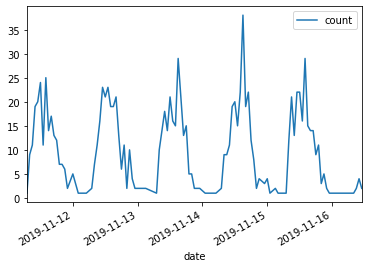

In [4]:
df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "localhost:9092") \
  .option("subscribe", "ANALYTIC-DEMO-UEBA") \
  .option("startingoffsets", "earliest")\
  .load()

wideDf = df.withColumn('json',col('value').cast('string')).\
    withColumn('evt', from_json(col('json'), json_schema)).\
    withColumn ('timestamp', to_timestamp(col('evt.EventTime.TimeCreated')).cast("timestamp")).\
    withColumn('operation', col('evt.EventDetail.TypeId')).\
    withColumn('streamid', col('evt.StreamId')).\
    withColumn('eventid', col('evt.EventId')).\
    withColumn ('user', coalesce(col('evt.EventSource.User.Id'),\
                                                col('evt.EventDetail.Authenticate.User.Id'))).\
    withWatermark("timestamp", "30 minutes").\
    dropDuplicates(["eventid", "streamid"])


wideDf.printSchema()

wideDf.createOrReplaceTempView("userops")

#userCounts=spark.sql("select user from userops")

userCounts = spark.sql("select user,operation, count (streamid, eventid) as events from userops \
                    group by user,operation")

#N.B. You cannot order results of the above, unless using outputMode("complete")
               
query = userCounts \
 .writeStream \
    .outputMode("update") \
    .format("console") \
    .start()

query.awaitTermination()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)
 |-- json: string (nullable = true)
 |-- evt: struct (nullable = true)
 |    |-- EventDetail: struct (nullable = true)
 |    |    |-- Authenticate: struct (nullable = true)
 |    |    |    |-- Action: string (nullable = true)
 |    |    |    |-- Outcome: struct (nullable = true)
 |    |    |    |    |-- Permitted: string (nullable = true)
 |    |    |    |    |-- Reason: string (nullable = true)
 |    |    |    |    |-- Success: string (nullable = true)
 |    |    |    |-- User: struct (nullable = true)
 |    |    |    |    |-- Id: string (nullable = true)
 |    |    |-- Process: struct (nullable = true)
 |    |    |    |-- Action: string (nullable = true)
 |    |    |    |-- Command: string (nullable = true)

KeyboardInterrupt: 